In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset
torch.cuda.set_device(1)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib import pyplot as plt
from collections import defaultdict

class PlotHelper():
    def __init__(self):
        self.reset()

    def reset(self):
        self._f = None
        self._ax = None
        self.kvals = defaultdict(list)

    def add(self, **kval):
        for k, v in kval.items():
            self.kvals[k].append(v)

    @property
    def fig(self):
        if self._f is None:
            self.new()
        return self._f

    @property
    def ax(self):
        if self._ax is None:
            self.new()
        return self._ax

    def new(self):
        self._f, self._ax = plt.subplots(1,1)
        plt.ion()
        self.fig.show()

    def show(self):
        names = []
        self.ax.clear()
        for k, v in self.kvals.items():
            names.append(k)
            self.ax.plot(v)
        self.ax.legend(names)
        self.fig.canvas.draw()

In [3]:
class SudokuSolver(nn.Module):
    def __init__(self, board_size):
        super().__init__()
        self.board_size = board_size
        
        prev_size = board_size
        sizes = [512] * 10 + [board_size]
        
        convolutions = []
        for size in sizes:
            convolutions.append(nn.Conv2d(prev_size, size, kernel_size=3, padding=1))
            prev_size = size
        
        self.convolutions = nn.ModuleList(convolutions)
        
    def __call__(self, X):
        
        for i in range(len(self.convolutions) - 1):
            X = F.relu(self.convolutions[i](X))
        X = self.convolutions[-1](X)
        
        return X.permute(0,2,3,1)

In [4]:
def process_inputs(X):
    is_input = X.sum(dim=3, keepdim=True)
    
    X = X.view(X.size(0), -1)
#     Y = Y.view(Y.size(0), -1)
    is_input = is_input.view(is_input.size(0), -1)
    
    return is_input

In [5]:
def show_sudoku(X):
    return (torch.argmax(X, 2) + 1) * (X.sum(2).long())

In [6]:
def isvalid_sudoku(X):
    return all([len(X[:, i].unique()) == 9 for i in range(9)])

In [7]:
with open('sudoku/features.pt', 'rb') as f:
    X = torch.load(f) # Shape: NxHxWxC 
    
with open('sudoku/labels.pt', 'rb') as f:
    Y = torch.load(f)
    
is_input = process_inputs(X)

In [8]:
# Input
print(show_sudoku(X[0])) # Shape of X_in: (BxHxWxC)

tensor([[6, 7, 0, 0, 0, 0, 0, 0, 5],
        [0, 0, 3, 0, 4, 0, 0, 8, 2],
        [0, 4, 0, 0, 0, 5, 1, 3, 6],
        [0, 0, 0, 7, 3, 0, 0, 9, 0],
        [3, 0, 4, 2, 0, 6, 0, 7, 0],
        [0, 0, 1, 0, 9, 0, 6, 0, 0],
        [5, 0, 9, 0, 0, 8, 0, 0, 0],
        [0, 0, 0, 9, 5, 0, 2, 0, 8],
        [0, 0, 0, 1, 2, 7, 4, 0, 0]])


In [9]:
# Groundtruth
print(show_sudoku(Y[0]))

tensor([[6, 7, 8, 3, 1, 2, 9, 4, 5],
        [1, 5, 3, 6, 4, 9, 7, 8, 2],
        [9, 4, 2, 8, 7, 5, 1, 3, 6],
        [2, 6, 5, 7, 3, 1, 8, 9, 4],
        [3, 9, 4, 2, 8, 6, 5, 7, 1],
        [7, 8, 1, 5, 9, 4, 6, 2, 3],
        [5, 2, 9, 4, 6, 8, 3, 1, 7],
        [4, 1, 7, 9, 5, 3, 2, 6, 8],
        [8, 3, 6, 1, 2, 7, 4, 5, 9]])


In [10]:
import sys
sys.path.append("..")


import torch.optim as optim
from pytorch_constraints.constraint import constraint
from pytorch_constraints.sampling_solver import WeightedSamplingSolver

model = SudokuSolver(9).cuda()
sudoku_constraint = constraint(isvalid_sudoku, WeightedSamplingSolver(num_samples=1000))
optimizer = optim.Adam(model.parameters(), lr=0.0001)

100%|██████████| 100/100 [03:06<00:00,  1.87s/it]


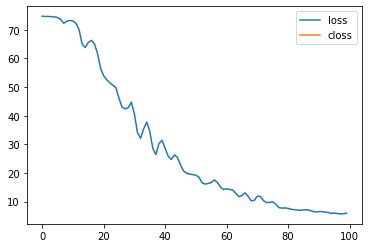

In [11]:
from tqdm import tqdm

X = X.permute(0,3,1,2).cuda() # Shape: (NxHxWxC) -> (NxCxHxW)
Y = Y[0].cuda()
is_input = is_input[0].cuda()

plot_loss = PlotHelper()

for i in tqdm(range(100)):
    optimizer.zero_grad()
    
    output = model(X[:1])
    
    loss = F.cross_entropy(output.view(-1,9), Y.argmax(dim=2).view(-1), reduction='none') * is_input
    closs = sudoku_constraint(output)
    
    total_loss = loss.sum() + closs
    
    plot_loss.add(loss=loss.sum().data, closs=closs.data)
    total_loss.backward()
    optimizer.step()
    
plot_loss.show()

### Model prediction:

In [12]:
output = model(X[:1])
print(output[0].argmax(dim=2) + 1)

tensor([[6, 7, 7, 8, 7, 8, 8, 3, 5],
        [2, 9, 3, 2, 4, 8, 8, 8, 2],
        [2, 4, 2, 2, 8, 5, 1, 3, 6],
        [2, 7, 4, 7, 3, 8, 3, 9, 1],
        [3, 7, 4, 2, 9, 6, 6, 7, 8],
        [2, 7, 1, 7, 9, 9, 6, 8, 1],
        [5, 6, 9, 7, 8, 8, 8, 8, 1],
        [2, 6, 6, 9, 5, 9, 2, 7, 8],
        [2, 6, 6, 1, 2, 7, 4, 7, 7]], device='cuda:1')


### Groundtruth:

In [13]:
Y.argmax(dim=2) + 1

tensor([[6, 7, 8, 3, 1, 2, 9, 4, 5],
        [1, 5, 3, 6, 4, 9, 7, 8, 2],
        [9, 4, 2, 8, 7, 5, 1, 3, 6],
        [2, 6, 5, 7, 3, 1, 8, 9, 4],
        [3, 9, 4, 2, 8, 6, 5, 7, 1],
        [7, 8, 1, 5, 9, 4, 6, 2, 3],
        [5, 2, 9, 4, 6, 8, 3, 1, 7],
        [4, 1, 7, 9, 5, 3, 2, 6, 8],
        [8, 3, 6, 1, 2, 7, 4, 5, 9]], device='cuda:1')

In [ ]:
isvalid_sudoku(output[0].argmax(dim=2)+1)

In [ ]:
print(show_sudoku(X_in[0]))

In [ ]:
X_in = X_in.permute(0,3,1,2)

In [ ]:
Out = SudokuSolver(9)(X_in[:1])

In [ ]:
Out = Out.permute(0,2,3,1)

In [ ]:
Out = Out.permute(0,3,1,2)

In [ ]:
show_sudoku(Out[0])

In [ ]:
print(show_sudoku(Y_in[0]))

In [ ]:
Y_in[0]
soln = show_sudoku(Y_in[0])

In [ ]:
all([len(soln[:, i].unique()) == 9 for i in range(9)])

In [ ]:
len(soln[0,:].unique()) == len(soln[0,:])

In [ ]:
len(soln[:3, :3].unique()) == len(soln[0,:])

In [ ]:
len(soln[:,1].unique()) == len(soln[0,:])